<a href="https://colab.research.google.com/github/Fame2875/TwitterSentimentAnalysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

67016018 ชนสรณ์ จึงมาริศกุล

Dataset จาก :https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

Target คือ การวิเคราะห์ข้อความบนทวิตเตอร์ว่าเป็นข้อความเชิงลบ กลางหรือบวก



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
import spacy

<h1>Reading The Data</h1>

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/twitter_training.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/twitter_validation.csv')


# Data Preprocessing - analysis

In [4]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


ข้อมูลไม่มี Header คอยกำกับ จึงจะทำการ Add header กำหนดเองเข้าไป

In [6]:
df_test.columns = ['Header1', 'company','sentiment','text']
df_train.columns = ['Header1', 'company','sentiment','text']

In [7]:
df_train.head()

,Header1,company,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
df_train.shape

(74681, 4)

In [9]:
df_test.shape

(999, 4)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Header1    74681 non-null  int64 
 1   company    74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Header1    999 non-null    int64 
 1   company    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [12]:
df_train.duplicated().sum()

2700

In [13]:
df_test.duplicated().sum()

0

In [14]:
df_train.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,686


In [15]:
df_test.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,0


Insight:<br>
Dataset Train  มี 74681 rows และ 4 columns<br>
Dataset Train มี NULL values ที่ Text อยู่ทั้งหมด 686 rows<br>
Dataset Train มี duplicates rows อยู่ที่ 2700 rows

Dataset Test  มี 999 rows และ 4 columns<br>
Dataset Test ไม่มี NULL value<br>
Dataset Test ไม่มี duplicates rows

เนื่องจากต้องการจะวิเคราะห์แค่ข้อความว่าเป็นด้านใด ทำให้ Header1 และ company ไม่จำเป็นต้องนำมาวิเคราะห์ สามารถ Drop ได้

# Data Preprocessing - Clean Data

<h2>ทำการดรอปข้อมูลที่ค่า Text เป็น 0 ออกเนื่องจากขาดมีข้อมูลที่สำคัญในการวิเคราะห์</h2>

In [16]:
df_train.dropna(inplace=True)

In [17]:
df_train.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,0


<h2>ทำการดรอปข้อมูลที่ duplicates</h2>

In [18]:
df_train.drop_duplicates(inplace=True)

In [19]:
df_train.duplicated().sum()

0

<h2>ทำการดรอป column </h2>

In [20]:
df_train.drop(columns=['Header1', 'company'], inplace=True)

In [21]:
df_test.drop(columns=['Header1', 'company'], inplace=True)

In [22]:
df_train

,sentiment,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [23]:
df_test

,sentiment,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


# Preprocessing the Data

**<h3>Lowercasing</h3>**

เปลี่ยนทุกตัวอักษรให้เป็น lower case เพื่อที่จะตัดปัญหา case-sensitive ออกไป

In [24]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

**<h3>Remove html tags,URLs, special characters,punctuations using Regular expressions</h3>**

In [25]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [26]:
# Clean the training data
df_train['text'] = df_train['text'].apply(clean_tweet)

In [27]:
# Clean the test data
df_test['text'] = df_test['text'].apply(clean_tweet)

In [28]:
df_train.head()

,sentiment,text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [29]:
df_test.head()

,sentiment,text
0,Neutral,bbc news amazon boss jeff bezos rejects claims...
1,Negative,why do i pay for word when it functions so poo...
2,Negative,csgo matchmaking is so full of closet hacking ...
3,Neutral,now the president is slapping americans in the...
4,Negative,hi i ve had madeleine mccann in my cellar for ...


In [30]:
df_train.duplicated().sum()

4973

<h2>เมื่อ Clean ข้อมูลเรียบร้อยแล้วพบว่ามีข้อมูล Duplicated เพิ่มจึงต้องทำการลบออกอีกที</h2>

In [31]:
df_train = df_train.drop_duplicates(subset=['text'])

<h2>Remove Emojis

In [32]:
# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # miscellaneous symbols
                                u"\U00002FC2-\U0001F251"  # additional symbols
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply the emoji removal to 'text' column of both training and test datasets
df_train['text'] = df_train['text'].apply(remove_emoji)
df_test['text'] = df_test['text'].apply(remove_emoji)

# Show the first few rows to verify the emoji removal
print(df_train[['text']].head())
print(df_test[['text']].head())


                                                text
0  i am coming to the borders and i will kill you...
1  im getting on borderlands and i will kill you all
2  im coming on borderlands and i will murder you...
3  im getting on borderlands and i will murder yo...
4  im getting into borderlands and i can murder y...
                                                text
0  bbc news amazon boss jeff bezos rejects claims...
1  why do i pay for word when it functions so poo...
2  csgo matchmaking is so full of closet hacking ...
3  now the president is slapping americans in the...
4  hi i ve had madeleine mccann in my cellar for ...


<ipython-input-32-bb780fddaed5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].apply(remove_emoji)


In [33]:
import re
import nltk
from nltk.corpus import stopwords

In [34]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')

# Get stopwords list
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [36]:
# Apply stopwords removal
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

# Show the first few rows to verify the cleaning process
print(df_train[['text']].head())
print(df_test[['text']].head())

                            text
0            coming borders kill
1    im getting borderlands kill
2   im coming borderlands murder
3  im getting borderlands murder
4  im getting borderlands murder
                                                text
0  bbc news amazon boss jeff bezos rejects claims...
1               pay word functions poorly chromebook
2  csgo matchmaking full closet hacking truly awf...
3  president slapping americans face really commi...
4  hi madeleine mccann cellar past years little s...


<ipython-input-36-5110ab203e00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].apply(remove_stopwords)


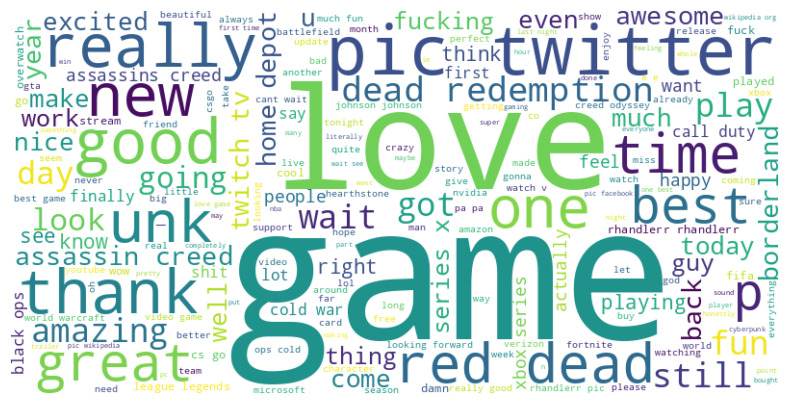

In [37]:
from wordcloud import WordCloud
# Corrected code for creating the word cloud
word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Positive"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(word_cloud_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h3>Word Cloud แสดงความรู้สึกเชิงบวก:</h3>


*   คำที่ชัดเจนที่สุด ได้แก่ "game" "love" "thank" "best" และ "amazing" ซึ่งสะท้อนว่าผู้คนมักแสดงความรู้สึกเชิงบวกเมื่อพูดถึงสิ่งที่พวกเขาชื่นชอบหรือซาบซึ้ง เช่น เกมหรือประสบการณ์ต่าง ๆ
*   คำอย่าง "thank" "love" และ "best" แสดงถึงความรู้สึกขอบคุณและชื่นชม ในขณะเดียวกันคำที่เกี่ยวข้องกับการเล่นเกม เช่น "game" "play" และ "fun" มีการใช้อย่างแพร่หลายซึ่งชี้ให้เห็นว่าการเล่นเกมเป็นหัวข้อที่ได้รับความนิยมในข้อความที่มีความรู้สึกเชิงบวก






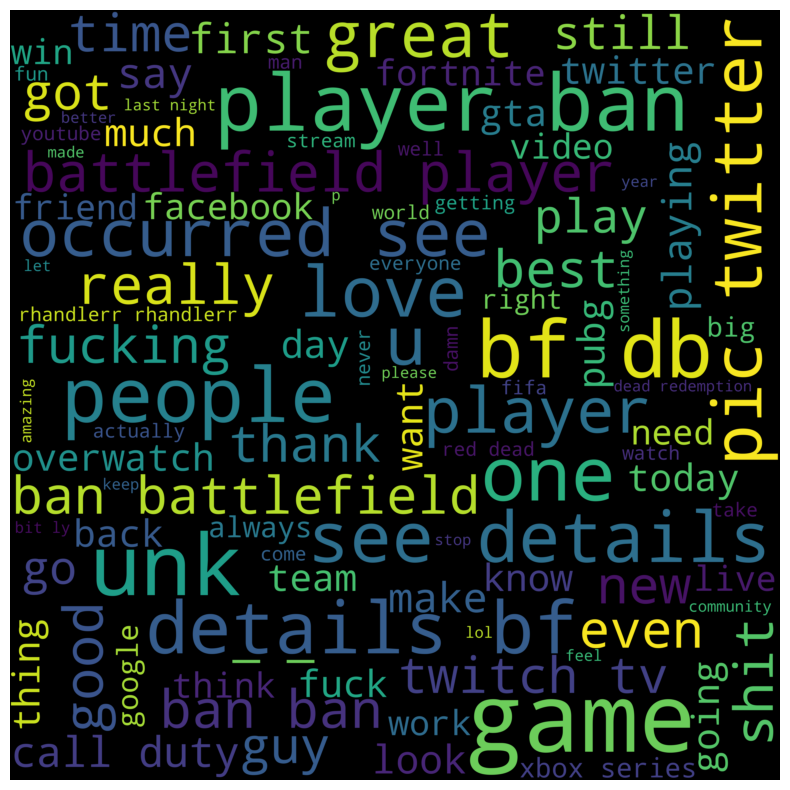

In [38]:

word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Irrelevant"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Word Cloud แสดงความรู้สึกเชิงลบ:


*   ใน word cloud ของข้อความเชิงลบพบคำเช่น "game" "player" "ban" "details" และ "team" อยู่บ่อยครั้ง นอกจากนี้ยังปรากฏคำที่มีลักษณะหยาบคายหรือเชิงลบ (เช่น "fucking" หรือ "shit") ซึ่งอาจสะท้อนลักษณะของบทสนทนาที่ไม่สร้างสรรค์หรือไม่มีประโยชน์

*   แม้กลุ่มนี้จะพบคำว่า "game" เช่นกันแต่การปรากฏของคำอย่าง "ban" และ "player" รวมถึงคำหยาบคายแสดงว่าข้อความเหล่านี้อาจเกี่ยวข้องกับการวิจารณ์หรือการสนทนาเชิงลบ เช่น การร้องเรียน หรือบทสนทนาที่ไม่สร้างสรรค์เกี่ยวกับเกม การแบนหรือพฤติกรรมในเกม เป็นต้น



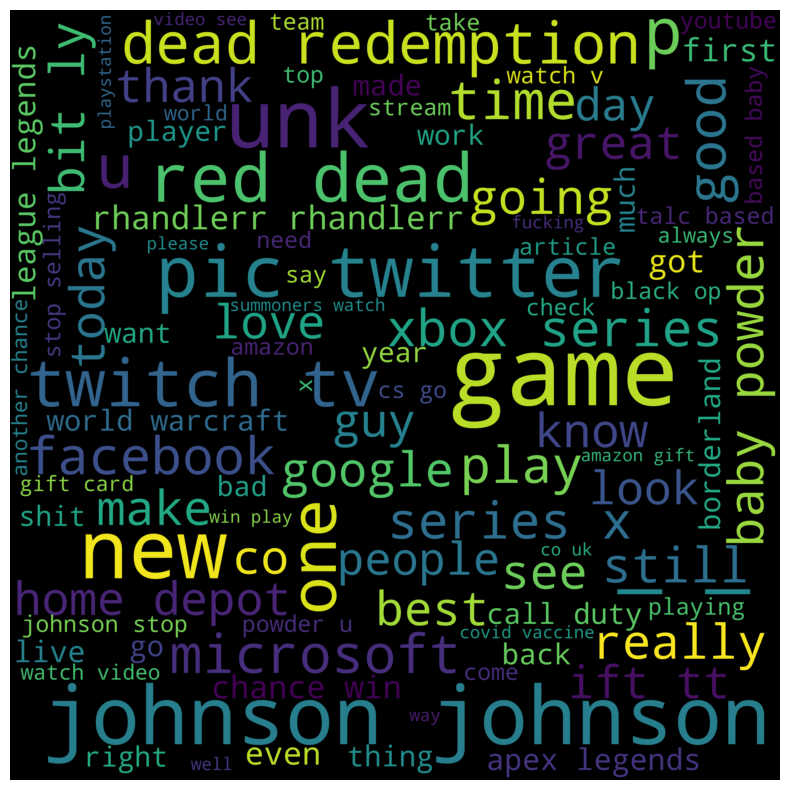

In [39]:
# Corrected code for creating the word cloud for "Neutral" type
word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Neutral"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



*   คำว่า "game" เป็นคำที่เด่นที่สุด ซึ่งอาจบ่งบอกถึงความถี่ในการพูดคุยเกี่ยวกับเกม
*   คำสำคัญอื่นๆ เช่น "johnson", "twitch", "facebook", "google", และ "red dead" บ่งบอกถึงการสนทนาเกี่ยวกับแพลตฟอร์ม บุคคล หรือหัวข้อที่เป็นที่นิยมในชุดข้อมูล ซึ่งสอดคล้องกับความเป็นข้อความที่มีอารมณ์เป็นกลาง
*   นอกจากคำว่า "game" แล้วยังมีคำอย่าง "red dead", "xbox", "microsoft", และ "play" ซึ่งบ่งบอกถึงการสนทนาเกี่ยวกับเครื่องเล่นเกมและเกมที่เฉพาะเจาะจง เช่น Red Dead Redemption
*   คำที่มีอารมณ์เป็นกลางอื่นๆ เช่น "people", "day", "love", และ "time" ชี้ให้เห็นว่าชุดข้อมูลอาจประกอบด้วยการสนทนาในชีวิตประจำวันหรือหัวข้อทั่วไป ไม่จำกัดแค่เรื่องเกมเท่านั้น


*   รายการในลิสต์
*   รายการในลิสต์





<h2>Split the Data</h2>

In [40]:
# Separate features and labels for training data
train_texts = df_train['text'].values
train_labels = df_train['sentiment'].values

# Separate features and labels for test data
test_texts = df_test['text'].values
test_labels = df_test['sentiment'].values

In [41]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [42]:
# Initialize the tokenizer
tokenizer = Tokenizer()  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [43]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [44]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 163


In [45]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [46]:
# Embedding Input Size
input_size = np.max(train_padded) + 1
input_size

29255

Dataset Preparation:


*   ใช้ LabelEncoder ในการเข้ารหัสป้ายกำกับเป็นตัวเลขเพื่อให้ง่ายต่อการประมวลผล

*   ใช้ Tokenizer ในการแปลงข้อความเป็นลำดับของโทเค็น ซึ่งจะถูกปรับขนาดด้วย pad_sequences ให้มีความยาวเท่ากัน (maxlen) เพื่อให้สอดคล้องกัน
*   ข้อมูลข้อความถูกแบ่งออกเป็นชุดข้อมูลสำหรับการฝึกและการทดสอบ (df_train และ df_test)






# Modeling

In [54]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(56,)))

# Add a bidirectional LSTM layer with 128 units and reduced regularization
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.002), recurrent_regularizer=l2(0.002), return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Lowered dropout

# Add another LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.002), recurrent_regularizer=l2(0.002))))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Lowered dropout

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

# Add dropout regularization
model.add(Dropout(0.4))  # Lowered dropout

# Add the output layer with 5 units for 5 labels and softmax activation
model.add(Dense(5, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 56, 100)             │       2,925,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 56, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,057 (13.63 MB)

 Trainable params: 3,572,033 (13.63 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [56]:
from keras.optimizers import Adam
# Compile with gradient clipping
optimizer = Adam(clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [57]:
# Implement learning rate scheduler
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history = model.fit(
    train_padded,
    train_labels_encoded,
    validation_data=(test_padded, test_labels_encoded),
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.4905 - loss: 2.5463 - val_accuracy: 0.7588 - val_loss: 0.8747 - learning_rate: 0.0010
Epoch 2/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.8474 - loss: 0.5877 - val_accuracy: 0.8248 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 3/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.8963 - loss: 0.3958 - val_accuracy: 0.8058 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 4/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.9142 - loss: 0.3317 - val_accuracy: 0.9269 - val_loss: 0.2979 - learning_rate: 0.0010
Epoch 5/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 73s 35ms/step - accuracy: 0.9264 - loss: 0.2983 - val_accuracy: 0.9229 - val_loss: 0.3384 - learning_rate: 0.0010
Epoch 6/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - accuracy: 0.9297 - loss: 0.2791 - val_accuracy: 0.9489 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 7/20
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 73s 35ms/step - accura

Evaluate the mode

In [58]:
test_loss, test_accuracy = model.evaluate(test_padded , test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9543 - loss: 0.2399
Test Loss: 0.22244372963905334
Test Accuracy: 0.9569569826126099


Visualize training history

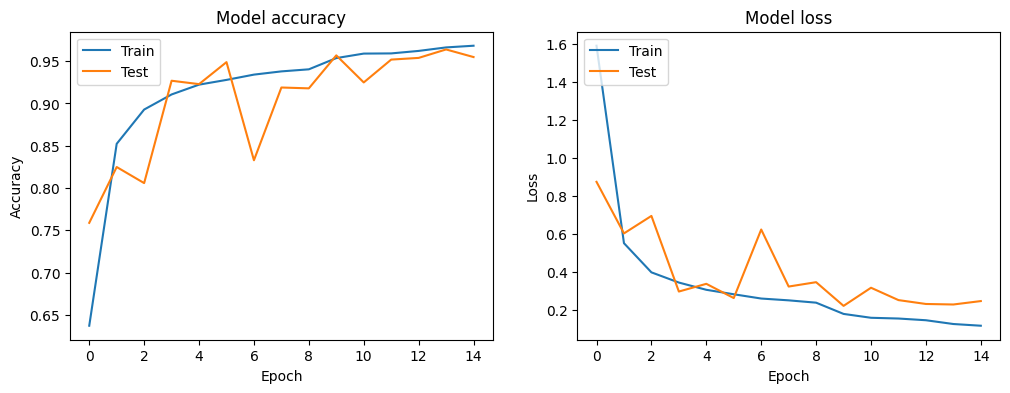

In [59]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Accuracy and Loss Graphs :



*  Accuracy ในการฝึก (เส้นสีน้ำเงิน): Accuracy ของชุดข้อมูลฝึกดีขึ้นอย่างต่อเนื่อง และเกือบถึง 1.0 หลังจากประมาณ 8 epochs แสดงให้เห็นว่าโมเดลเรียนรู้ชุดข้อมูลฝึกได้ดีมาก

*   Accuracy ของชุดทดสอบ (เส้นสีส้ม): Accuracy ของชุดทดสอบเริ่มต้นดีตามชุดฝึก แต่มีความผันผวนมากขึ้นเมื่อเวลาผ่านไป หลังจากประมาณ 6-8 epochs Accuracy ของชุดทดสอบมีความเสถียรมากขึ้น แต่ยังคงมีความผันผวนเล็กน้อย
*   ความใกล้เคียงระหว่าง Accuracy ของชุดฝึกและชุดทดสอบแสดงให้เห็นว่าโมเดลทำงานได้ดีและสามารถทำนายข้อมูลที่ไม่เคยเห็นได้โดยไม่มีการ overfitting มากนัก แต่ก็ยังมีการ overfitting อยู่เล็กน้อย



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


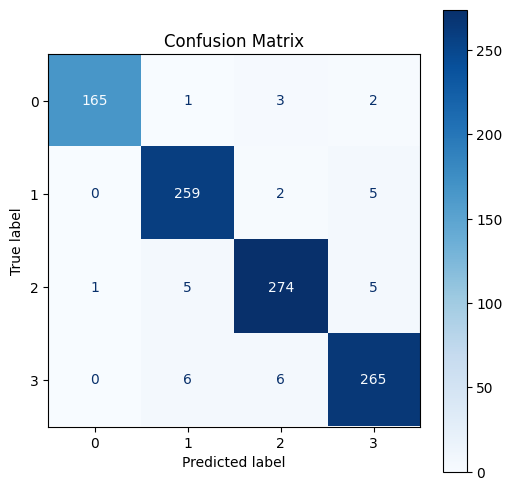

In [53]:
# Generate predictions and plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions on the test set
y_pred = model.predict(test_padded)  # Predict based on the current model in memory
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax outputs to predicted class labels

# Assuming test_labels_encoded is your ground truth
y_true = test_labels_encoded

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Use 'Blues' colormap for better visualization
plt.title('Confusion Matrix')
plt.show()

confusion matrix :


*   ค่าบนเส้นทแยงมุมของ Matrix สูงสำหรับทุก Class ซึ่งแปลว่าโมเดลทำนายถูกต้องเป็นส่วนใหญ่


*   มีการทำนายผิดเพียงเล็กน้อยและไม่บ่อย ซึ่งหมายความว่าโมเดลมีความแม่นยำสูง แต่ยังมีการสับสนระหว่าง Class ที่อยู่ติดกัน เช่น Class 1 บางครั้งถูกทำนายเป็น Class 0 หรือ Class 2
*   กราฟ accuracy แสดงให้เห็นถึงแนวโน้มของการฝึกและการตรวจสอบที่มีค่าความถูกต้องสูงสุดใกล้เคียงกับ 0.95 ซึ่งบ่งชี้ว่าโมเดลมีการ generalize ได้ดี


*   ความสมดุลของ Class: จำนวนการทำนายที่ถูกต้องกระจายไปอย่างดีในทุก Class แสดงว่าโมเดลไม่มีความเอนเอียงไปยัง Class ใดเป็นพิเศษ




Test model

In [37]:
CVS_PATH="/content/Twitter_Data.csv"

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
import spacy

In [39]:
df =pd.read_csv(CVS_PATH)

In [41]:
df = df.rename(columns={'clean_text': 'text', 'category': 'sentiment'})

In [42]:
df

,text,sentiment
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0
